In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score
import shap
shap.initjs()
%matplotlib inline



In [2]:
data = pd.read_csv("../processing/merged_data.csv", index_col=[0])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,componentindex_249.0,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp
1.0,0,1,0,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
2.0,0,1,1,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
3.0,0,1,1,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
4.0,0,1,1,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
5.0,0,1,1,1,0,0,0,1,1,1,...,0,1,0,0,0,0,1,0,0,1


In [3]:
data2 = data.drop('infection_status', axis=1)
labels = data['infection_status']

We start with some functions to train, test and do 6-fold cross validation.

In [4]:
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 6, shuffle=True, random_state=2)
    for train_index, test_index in kf.split(data2):
        train_features, test_features = data2.iloc[train_index], data2.iloc[test_index]
        train_labels, test_labels = labels.iloc[train_index], labels.iloc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

Below we will train different neural networks with 1, 2 or 3 layers and a differing number of neurons. We can then plot the accuracies and see if we can improve.

[0.9527914614121511, 0.9646962233169131, 0.9587438423645321, 0.9527914614121511, 0.9646962233169131, 0.970648604269294]


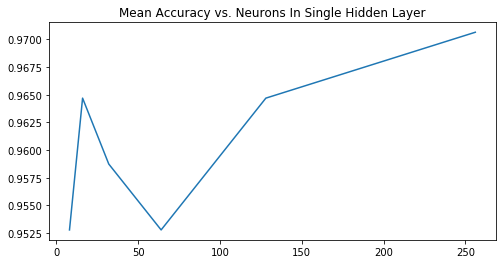

In [5]:
nn_one_neurons = [
    (8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (256,),
]
nn_one_accuracies = []

for n in nn_one_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_one_accuracies.append(nn_mean_accuracy)

print(nn_one_accuracies)    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Single Hidden Layer")

x = [i[0] for i in nn_one_neurons]
plt.plot(x, nn_one_accuracies)

Looks like a single layer with 256 neurons gives around 97%, that's pretty impressive.

[0.9525862068965517, 0.9585385878489326, 0.9646962233169131]


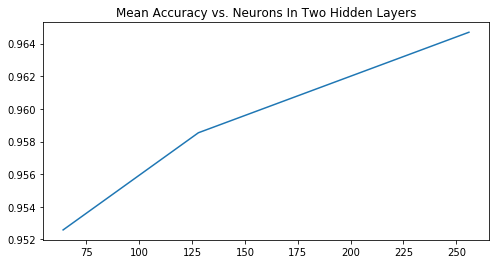

In [6]:
nn_two_neurons = [
    (64,64),
    (128, 128),
    (256, 256)
]
nn_two_accuracies = []

for n in nn_two_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_two_accuracies.append(nn_mean_accuracy)

print(nn_two_accuracies)
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Two Hidden Layers")

x = [i[0] for i in nn_two_neurons]
plt.plot(x, nn_two_accuracies)

[0.9646962233169131, 0.9466338259441708, 0.9589490968801314]


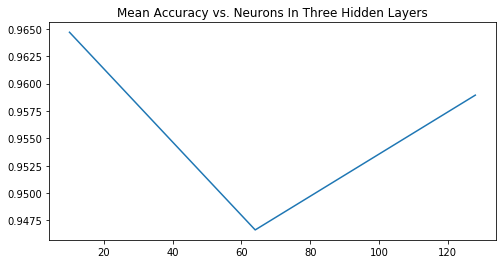

In [7]:
nn_three_neurons = [
    (10, 10, 10),
    (64, 64, 64),
    (128, 128, 128)
]

nn_three_accuracies = []

for n in nn_three_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_three_accuracies.append(nn_mean_accuracy)

print(nn_three_accuracies)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Three Hidden Layers")

x = [i[0] for i in nn_three_neurons]
plt.plot(x, nn_three_accuracies)

It looks like the average accuracy doesn't improve by adding more layers, so we can stick with a single layer and 256 nodes.

In [8]:
mlp = MLPClassifier(hidden_layer_sizes=(256,))
mlp.fit(data2, labels)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(256,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Using 171 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


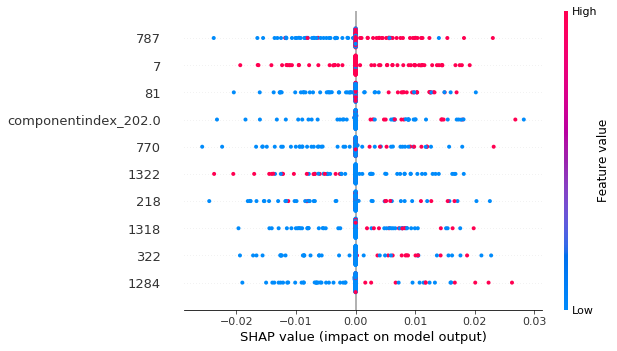

In [9]:
explainer = shap.KernelExplainer(mlp.predict, data2)
shap_values = explainer.shap_values(data2)
shap.summary_plot(shap_values, data2, max_display=10)

This took a little while to produce and you can see that this is very different to our other models. The output still uses compound 787 as the top feature though, that's interesting. I guess this is one we should definitely look more closely at. 

In [15]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data2.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance = feature_importance[:25]
feature_importance.to_csv('NN_top25.csv')